In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm
import os
import time
from tensorboardX import SummaryWriter

#from envs.burgers import Burgers
from buffer import OfflineReplayBuffer
from critic import ValueLearner, QPiLearner, QSarsaLearner
from bppo import BehaviorCloning, BehaviorProximalPolicyOptimization

In [2]:
# Hyperparameters

# Experiment
env_name='burger'
path='logs'
log_freq=int(100)
seed=20241219
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
N=100 # Number of trajectories to collect for offline dataset

# For Value
v_steps=int(5000)
v_hidden_dim = 256
v_depth = 3
v_lr = 1e-6
v_batch_size = 64

# For Q
q_bc_steps=int(5000)
q_pi_steps=10 # Number of steps to update Q-network in each iteration. Only used if is_offpolicy_update=True.
q_hidden_dim = 256
q_depth = 3
q_lr = 1e-6
q_batch_size = 64
target_update_freq=2
tau=0.005 # Soft update rate for target Q network parameters. See Q_learner.update()
gamma=0.99 # Discount factor for calculating the return.
is_offpolicy_update=False # Whether to use advantage replacement (as proposed in the BPPO paper) in Q-learning.
# If False, use Q-learning to update the Q-network parameters in each iteration.
# If True, only update the Q-network parameters once, and keep using this Q-network.

# For BC
bc_steps=int(500)
bc_lr = 1e-4
bc_hidden_dim = 256
bc_depth = 3
bc_batch_size = 64

# For BPPO
bppo_steps=int(100)
bppo_hidden_dim = 256
bppo_depth = 3
bppo_lr = 1e-4
bppo_batch_size = 64
clip_ratio=0.25 # PPO clip ratio. The probability ratio between new and old policy is clipped to be in the range [1-clip_ratio, 1+clip_ratio]
entropy_weight=0.00 # Weight of entropy loss in PPO and BPPO. Can be set to 0.01 for medium tasks.
decay=0.96 # Decay rate of PPO clip ratio
omega=0.9 # Related to setting the weight of advantage (see PPO code)
is_clip_decay=True # Whether to decay the clip_ratio during training
is_bppo_lr_decay=True # Whether to decay the learning rate of BPPO during trainining
is_update_old_policy=True # Whether to update the old policy of BPPO in each iteration. The old policy is used to calculate the probability ratio.
is_state_norm=False # Whether to normalize the states of the dataset.

# Other Settings
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device=torch.device('cpu')
state_dim = 128
action_dim = 128
x_range=(-5,5)



In [3]:
#env=Burgers(
#    n=state_dim,
#    m=action_dim,
#    T=8,
#    x_range=[-1,1],
#    energy_penalty=0.01,
#    device='cpu'
#)

In [3]:
from generate_burgers import load_burgers

dataset = load_burgers(
                x_range=x_range,
                nt = 500, # Number of time steps
                nx = state_dim, # Number of spatial nodes (grid points)
                dt= 0.001, # Temporal interval
                N = 1, # Number of samples (trajectories) to generate
                visualize=False # Whether to show the animation of state trajectory evolution
                )

for key in dataset.keys():
    if key!="meta_data":
        dataset[key]=dataset[key].squeeze(0)

print(dataset['observations'].shape)
print(dataset['actions'].shape)
print(dataset['rewards'].shape)
print(dataset['terminals'].shape)
print(dataset['timeouts'].shape)

Setting rewards: 100%|██████████| 1/1 [00:00<00:00, 996.98it/s]

Y_bar shape:  (1, 500, 128)
Y_f shape:  (1, 128)
U shape:  (1, 500, 128)
Terminals shape:  (1, 500)
Timeouts shape:  (1, 500)
Rewards shape:  (1, 500)
(500, 128)
(500, 128)
(500,)
(500,)
(500,)


In [4]:
replay_buffer = OfflineReplayBuffer(device, state_dim, action_dim, len(dataset['actions']))
replay_buffer.load_dataset(dataset=dataset)
replay_buffer.compute_return(gamma) # Compute the discounted return for the trajectory, with a discount factor of gamma (default 0.99).

Computing the returns: 499it [00:00, 208358.16it/s]


In [5]:
# summarywriter logger
# path

current_time = time.strftime("%Y_%m_%d__%H_%M_%S", time.localtime())
path = os.path.join(path, str(seed))
os.makedirs(os.path.join(path, current_time))
print(f'Made log directory at {os.path.join(path, current_time)}')

logger_path = os.path.join(path, current_time)
logger = SummaryWriter(log_dir=logger_path, comment='')

Made log directory at logs\20241219\2024_12_22__09_18_41


In [14]:
# initilize
value = ValueLearner(device=device,
                        state_dim=state_dim,
                        hidden_dim=v_hidden_dim,
                        depth=v_depth,
                        value_lr=v_lr,
                        batch_size=v_batch_size)

Q_bc = QSarsaLearner(device=device,
                        state_dim=state_dim,
                        action_dim=action_dim,
                        hidden_dim=q_hidden_dim, depth=q_depth,
                        Q_lr=q_lr,
                        target_update_freq=target_update_freq,
                        tau=tau,
                        gamma=gamma,
                        batch_size=q_batch_size)
if is_offpolicy_update: 
    Q_pi=QPiLearner(device=device,
                        state_dim=state_dim,
                        action_dim=action_dim,
                        hidden_dim=q_hidden_dim,
                        depth=q_depth,
                        Q_lr=q_lr,
                        target_update_freq=target_update_freq,
                        tau=tau,
                        gamma=gamma,
                        batch_size=q_batch_size)
bc=BehaviorCloning(device=device,
                        state_dim=state_dim,
                        hidden_dim=bc_hidden_dim,
                        depth=bc_depth,
                        action_dim=action_dim,
                        policy_lr=bc_lr,
                        batch_size=bc_batch_size)
bppo=BehaviorProximalPolicyOptimization(device=device,
                        state_dim=state_dim,
                        hidden_dim=bppo_hidden_dim,
                        depth=bppo_depth,
                        action_dim=action_dim,
                        policy_lr=bppo_lr,
                        clip_ratio=clip_ratio,
                        entropy_weight=entropy_weight,
                        decay=decay,
                        omega=omega,
                        batch_size=bppo_batch_size)

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

class ValueLearner(nn.Module):
    def __init__(
        self, 
        device: torch.device, 
        state_dim: int, 
        hidden_dim: int, 
        depth: int, 
    ) -> None:
        super().__init__()
        self._device = device


        '''
        layers = [nn.Linear(state_dim, hidden_dim), nn.ReLU()]
        for _ in range(depth -1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 1))
        #layers.append(nn.ReLU())
    
        self.net = nn.Sequential(*layers).to(device)
        '''
        self.layer1=nn.Linear(state_dim,hidden_dim).to(device)
        self.relu1=nn.ReLU().to(device)
        self.layer2=nn.Linear(hidden_dim,1).to(device)
        self.relu2=nn.ReLU().to(device)
        

    def forward(self,
        s: torch.Tensor
    ) -> torch.Tensor:
        s = self.layer1(s)
        s = self.relu1(s)
        s = self.layer2(s)
        s = self.relu2(s)
        return s


    def save(
        self, path: str
    ) -> None:
        torch.save(self.net.state_dict(), path)
        print('Value parameters saved in {}'.format(path))


    def load(
        self, path: str
    ) -> None:
        self.net.load_state_dict(torch.load(path, map_location=self._device))
        print('Value parameters loaded')

value_learner = ValueLearner(device='cpu',
                        state_dim=state_dim,
                        hidden_dim=v_hidden_dim,
                        depth=v_depth,)

In [39]:
# value training 
value_path = os.path.join(path, 'value.pt')
if os.path.exists(value_path):
    value.load(value_path)
else:
    criterion = nn.MSELoss()  # 均方误差损失
    optimizer = optim.Adam(value.net.parameters(), lr=1e-3)
    for step in tqdm.tqdm(range(int(v_steps)), desc='value updating ......'):
        value_learner.train()  # 设置模型为训练模式
        s, _, _, _, _, _, Return, _ = replay_buffer.sample(128)
        # 前向传播
        outputs = value(s)
        loss = criterion(outputs, Return)

        # 反向传播和优化
        optimizer.zero_grad()  # 清空之前的梯度
        loss.backward()        # 计算梯度
        optimizer.step()       # 更新参数
        
        if step % int(log_freq) == 0:
            print(f"Step: {step}, Loss: {loss.item():.4f}")
            logger.add_scalar('value_loss', loss, global_step=(step+1))
    value_learner.save(value_path)

value updating ......:   1%|          | 54/5000 [00:00<00:18, 265.63it/s]

Step: 0, Loss: 611.8718


value updating ......:   3%|▎         | 138/5000 [00:00<00:18, 266.70it/s]

Step: 100, Loss: 627.7278


value updating ......:   5%|▌         | 255/5000 [00:00<00:17, 267.30it/s]

Step: 200, Loss: 681.9622


value updating ......:   7%|▋         | 337/5000 [00:01<00:17, 263.04it/s]

Step: 300, Loss: 663.4417


value updating ......:   9%|▉         | 448/5000 [00:01<00:17, 264.21it/s]

Step: 400, Loss: 729.2269


value updating ......:  11%|█         | 528/5000 [00:02<00:18, 245.54it/s]

Step: 500, Loss: 456.2892


value updating ......:  13%|█▎        | 638/5000 [00:02<00:16, 265.34it/s]

Step: 600, Loss: 589.1162


value updating ......:  15%|█▍        | 746/5000 [00:02<00:16, 258.29it/s]

Step: 700, Loss: 493.3994


value updating ......:  17%|█▋        | 835/5000 [00:03<00:16, 253.49it/s]

Step: 800, Loss: 692.4723


value updating ......:  19%|█▉        | 948/5000 [00:03<00:15, 263.59it/s]

Step: 900, Loss: 621.7665


value updating ......:  21%|██▏       | 1064/5000 [00:04<00:13, 282.71it/s]

Step: 1000, Loss: 542.8847


value updating ......:  23%|██▎       | 1149/5000 [00:04<00:14, 261.96it/s]

Step: 1100, Loss: 610.6831


value updating ......:  23%|██▎       | 1162/5000 [00:04<00:14, 259.38it/s]


KeyboardInterrupt: 

Epoch [100/1000], Loss: 349.2013
Epoch [200/1000], Loss: 197.9289
Epoch [300/1000], Loss: 61.6658
Epoch [400/1000], Loss: 17.2879
Epoch [500/1000], Loss: 14.2019
Epoch [600/1000], Loss: 11.9564
Epoch [700/1000], Loss: 6.7162
Epoch [800/1000], Loss: 4.4973
Epoch [900/1000], Loss: 3.3177
Epoch [1000/1000], Loss: 4.4639


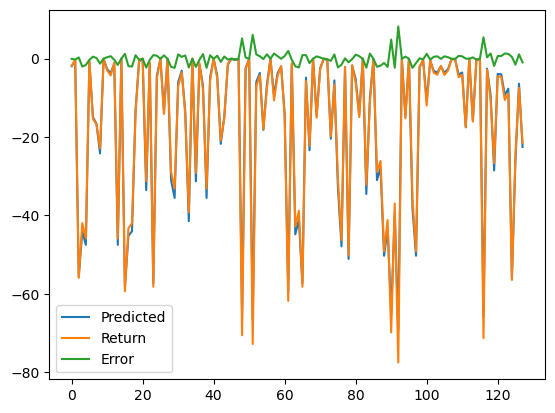

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义MLP模型
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 设置超参数
input_size = 128   # 输入特征维度
hidden_size = 64   # 隐藏层神经元数量
output_size = 1    # 输出维度
num_epochs = 1000  # 训练轮数
learning_rate = 0.001  # 学习率

# 创建模型、损失函数和优化器
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # 均方误差损失
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 假设s和Return已经是PyTorch张量
# s形状为(1000, 128)，Return形状为(1000, 1)

# 训练模型
for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    s, _, _, _, _, _, Return, _ = replay_buffer.sample(128)
    # 前向传播
    outputs = model(s)
    loss = criterion(outputs, Return)

    # 反向传播和优化
    optimizer.zero_grad()  # 清空之前的梯度
    loss.backward()        # 计算梯度
    optimizer.step()       # 更新参数

    # 打印损失
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 训练完成后，可以使用模型进行预测
s1, _, _, _, _, _, Return1, _ = replay_buffer.sample(128)
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    predicted1 = model(s1)  # 通过训练好的模型进行预测

plt.plot(predicted1.detach().numpy(), label='Predicted')
plt.plot(Return1.numpy(), label='Return')
plt.plot(predicted1.detach().numpy() - Return1.numpy(), label='Error')
plt.legend()
plt.show()

In [23]:
# value training 
value_path = os.path.join(path, 'value.pt')
if os.path.exists(value_path):
    value.load(value_path)
else:
    for step in tqdm.tqdm(range(int(v_steps)), desc='value updating ......'):
        value_loss = value.update(replay_buffer)
        
        if step % int(log_freq) == 0:
            print(f"Step: {step}, Loss: {value_loss:.4f}")
            logger.add_scalar('value_loss', value_loss, global_step=(step+1))
    value.save(value_path)

# Q_bc training
Q_bc_path = os.path.join(path, 'Q_bc.pt')
if os.path.exists(Q_bc_path):
    Q_bc.load(Q_bc_path)
else:
    for step in tqdm.tqdm(range(int(q_bc_steps)), desc='Q_bc updating ......'):
        Q_bc_loss = Q_bc.update(replay_buffer, pi=None)
        if step % int(log_freq) == 0:
            print(f"Step: {step}, Loss: {Q_bc_loss:.4f}")
            logger.add_scalar('Q_bc_loss', Q_bc_loss, global_step=(step+1))
    Q_bc.save(Q_bc_path)

if is_offpolicy_update:
    Q_pi.load(Q_bc_path)



value updating ......:   0%|          | 0/5000 [00:00<?, ?it/s]


AttributeError: 'ValueLearner' object has no attribute 'update'

In [9]:
mean, std = 0., 1.

# bc training
best_bc_path = os.path.join(path, 'bc_best.pt')
if os.path.exists(best_bc_path):
    bc.load(best_bc_path)
else:
    best_bc_score = 0
    for step in tqdm.tqdm(range(int(bc_steps)), desc='bc updating ......'):
        bc_loss = bc.update(replay_buffer)
        if step % int(log_freq) == 0:
            current_bc_score = bc.offline_evaluate(env_name, seed, mean, std)
            if current_bc_score > best_bc_score:
                best_bc_score = current_bc_score
                bc.save(best_bc_path)
                np.savetxt(os.path.join(path, 'best_bc.csv'), [best_bc_score], fmt='%f', delimiter=',')
            print(f"Step: {step}, Loss: {bc_loss:.4f}, Score: {current_bc_score:.4f}")
            logger.add_scalar('bc_loss', bc_loss, global_step=(step+1))
            logger.add_scalar('bc_score', current_bc_score, global_step=(step+1))
    bc.save(os.path.join(path, 'bc_last.pt'))
    bc.load(best_bc_path)



bc updating ......:   0%|          | 0/500 [00:00<?, ?it/s]


AttributeError: 'str' object has no attribute 'reset'

In [ ]:
# bppo training
bppo.load(best_bc_path)
best_bppo_path = os.path.join(path, current_time, 'bppo_best.pt')
Q = Q_bc # If advantage replacement, then Q_{\pi k}=Q_{\pi\beta}
best_bppo_score = bppo.offline_evaluate(env_name, seed, mean, std)
print('best_bppo_score:',best_bppo_score,'-------------------------')
for step in tqdm(range(int(bppo_steps)), desc='bppo updating ......'):
    if step > 200:
        is_clip_decay = False
        is_bppo_lr_decay = False
    bppo_loss = bppo.update(replay_buffer, Q, value, is_clip_decay, is_bppo_lr_decay)
    current_bppo_score = bppo.offline_evaluate(env_name, seed, mean, std) # J_{\pi k}
    if current_bppo_score > best_bppo_score:
        best_bppo_score = current_bppo_score
        print('best_bppo_score:',best_bppo_score,'-------------------------')
        bppo.save(best_bppo_path)
        np.savetxt(os.path.join(path, current_time, 'best_bppo.csv'), [best_bppo_score], fmt='%f', delimiter=',')
        if is_update_old_policy:
            bppo.set_old_policy() # Set the old policy to the current policy
    if is_offpolicy_update: # If not using advantage replacement, calculate Q_{\pi k} by Q-learning
        for _ in tqdm(range(int(q_pi_steps)), desc='Q_pi updating ......'): 
            Q_pi_loss = Q_pi.update(replay_buffer, bppo)
        Q = Q_pi
    print(f"Step: {step}, Loss: {bppo_loss:.4f}, Score: {current_bppo_score:.4f}")
    logger.add_scalar('bppo_loss', bppo_loss, global_step=(step+1))
    logger.add_scalar('bppo_score', current_bppo_score, global_step=(step+1))

logger.close()